In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000, 1)
y_test shape: (10000, 1)


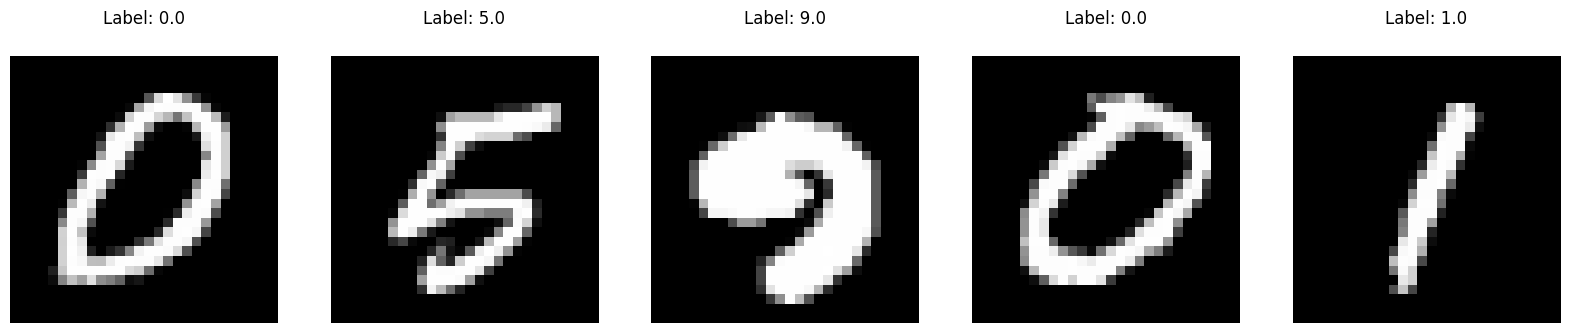

In [21]:
with np.load('mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k].astype('float32') for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
x_train = np.array(x_train).reshape((60000, 784))
x_test = np.array(x_test).reshape((10000, 784))

y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import keras_tuner as kt

def build_model(hp):
    hp_layers = hp.Int('layers', min_value=1, max_value=10, step=1)
    hp_learning_rate = hp.Float(
      'learning_rate',
      min_value=1e-6,
      max_value=1e-2,
      sampling='LOG',
      default=1e-3
    )
    
    model = Sequential()
       
    model.add(Input(shape=(784,)))
    
    for i in range(hp_layers):
      model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=2048, step=32), activation='relu'))
      model.add(Dropout(rate=hp.Float(
        f'dropout_rate_{i}',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
      )))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                    loss=SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tmp',
                     project_name='mnist_MLP')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train, y_train, epochs=500, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Найкращі параметри:\n")
print(best_hps.values)

Reloading Tuner from tmp/mnist_MLP/tuner0.json
Найкращі параметри:

{'layers': 9, 'learning_rate': 0.00022217325584420253, 'units_0': 1088, 'dropout_rate_0': 0.30000000000000004, 'units_1': 1312, 'dropout_rate_1': 0.05, 'units_2': 96, 'dropout_rate_2': 0.45, 'units_3': 96, 'dropout_rate_3': 0.2, 'units_4': 1152, 'dropout_rate_4': 0.2, 'units_5': 544, 'dropout_rate_5': 0.0, 'units_6': 736, 'dropout_rate_6': 0.05, 'units_7': 960, 'dropout_rate_7': 0.25, 'units_8': 1696, 'dropout_rate_8': 0.0, 'units_9': 960, 'dropout_rate_9': 0.05, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [24]:
hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(x_train, y_train, epochs=500, validation_split=0.2)

Epoch 1/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4448 - loss: 1.6593 - val_accuracy: 0.7641 - val_loss: 0.6069
Epoch 2/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7394 - loss: 0.6782 - val_accuracy: 0.8631 - val_loss: 0.3606
Epoch 3/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8210 - loss: 0.4771 - val_accuracy: 0.8621 - val_loss: 0.2976
Epoch 4/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8576 - loss: 0.3798 - val_accuracy: 0.9350 - val_loss: 0.2562
Epoch 5/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9189 - loss: 0.2828 - val_accuracy: 0.9548 - val_loss: 0.1928
Epoch 6/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9462 - loss: 0.2127 - val_accuracy: 0.9610 - val_loss: 0.1622
Epoch 7/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9547 - loss: 0.1886 - val_accuracy: 0.9664 - val_loss: 0.1390
Epoch 8/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9598 - loss: 0

In [25]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[Loss, Accuracy]:", eval_result)

290/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.2303

2025-03-17 23:36:39.380745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_52', 28 bytes spill stores, 28 bytes spill loads

2025-03-17 23:36:39.451610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_59', 304 bytes spill stores, 384 bytes spill loads

2025-03-17 23:36:39.549475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_52', 272 bytes spill stores, 320 bytes spill loads

2025-03-17 23:36:39.989468: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_80', 20 bytes spill stores, 20 bytes spill loads

2025-03-17 23:36:40.228396: I external/local_xla/xla/stream_exec

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9819 - loss: 0.2277
[Loss, Accuracy]: [0.2070523500442505, 0.9839000105857849]


In [32]:
predictions = hypermodel.predict(x_test).argmax(axis=1)

predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([7, 2, 1, ..., 4, 5, 6])

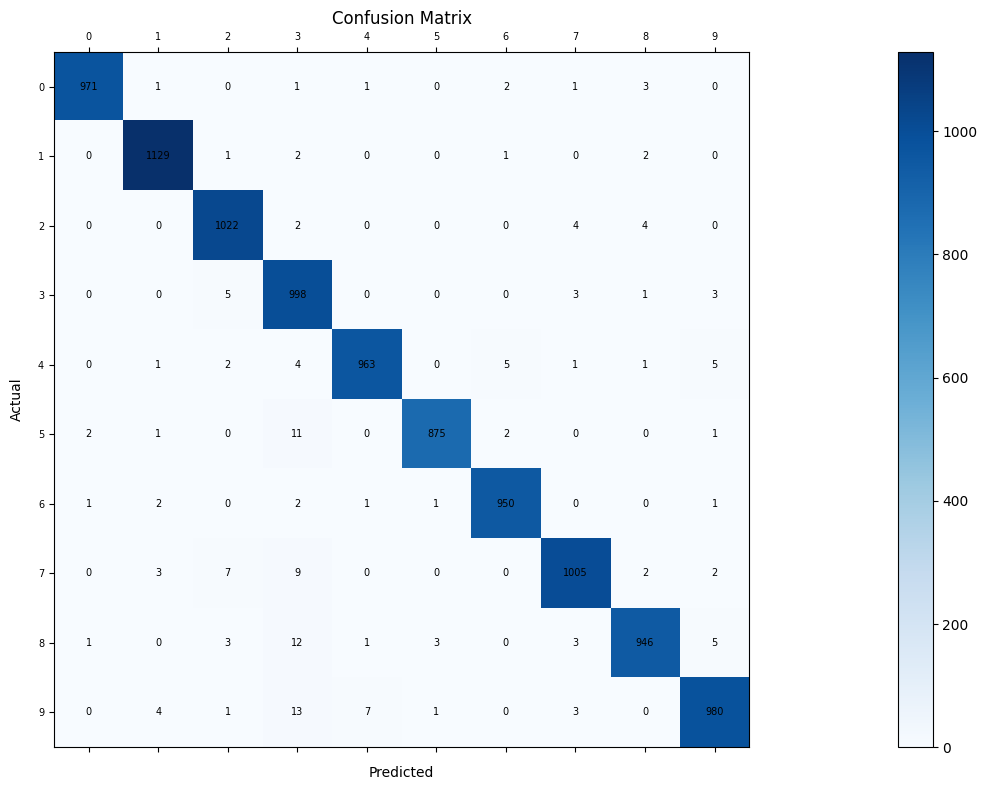

In [34]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(30, 8))
cax = ax.matshow(conf_matrix, cmap="Blues")

plt.colorbar(cax)

class_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=7)
ax.set_yticklabels(class_labels, fontsize=7)

plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted", labelpad=10)
plt.ylabel("Actual", labelpad=10)

for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()